In [15]:
import warnings
import matplotlib
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)
import os

In [3]:
import sys
sys.path.insert(0, '/home/krishna/Projects/Matterport3DSimulatorDocker/build_py385')
print(sys.path)
from tasks.R2R.env import R2RBatch
env = R2RBatch(None, connectivity_dir='./datasets/R2R/connectivity', batch_size=64, splits=['./datasets/R2R/annotations/R2R_train_enc.json',
                                            './datasets/R2R/annotations/R2R_val_seen_enc.json',
                                            './datasets/R2R/annotations/R2R_val_unseen_enc.json'])

['/home/krishna/Projects/Matterport3DSimulatorDocker/build_py385', '/home/krishna/Projects/VLN-BEVBert', '/home/krishna/miniconda3/envs/vlnduet/lib/python38.zip', '/home/krishna/miniconda3/envs/vlnduet/lib/python3.8', '/home/krishna/miniconda3/envs/vlnduet/lib/python3.8/lib-dynload', '', '/home/krishna/.local/lib/python3.8/site-packages', '/home/krishna/miniconda3/envs/vlnduet/lib/python3.8/site-packages']
Image features not provided
Loading navigation graphs for 72 scans
R2RBatch loaded with 17409 instructions, using splits: ./datasets/R2R/annotations/R2R_train_enc.json,./datasets/R2R/annotations/R2R_val_seen_enc.json,./datasets/R2R/annotations/R2R_val_unseen_enc.json


In [38]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import json
import random

from plot_utils import plot_each, plot_gif
from tasks.R2R.eval import Evaluation
e = Evaluation(['./datasets/R2R/annotations/R2R_train_enc.json',
                './datasets/R2R/annotations/R2R_val_seen_enc.json',
                './datasets/R2R/annotations/R2R_val_unseen_enc.json'], 
               connectivity_dir='./datasets/R2R/connectivity')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def grab_traj(outfile):
    with open(outfile) as f:
        epis = e.inspect_results(json.load(f))

    return epis

def grab_kidnap_locs(outfile):
    epis = {}
    with open(outfile) as f:
        for epi in f:
            epi_ = json.loads(epi)
            epis[f"{epi_['instr_id']}/{epi_['env']}"] = epi_ 
    return epis

def get_ground_truth(instr_id):
    gt = e.gt[int(instr_id.split('_')[0])]
    item = {'instr_id': instr_id, 'path': gt['path']}
    return item

In [39]:
########### INPUT THE DESIRED TRAJECTORIES HERE
#outfolder = ''
#print(os.listdir(outfolder))

def get_eval_trajs(model1, model2, model1_folder, model2_folder, split, print_stats=False):
    model1_results = os.path.join('/home/krishna/Projects/',model1, model1_folder, f'preds/detail_{split}.json')
    model2_results = os.path.join('/home/krishna/Projects/',model2, model2_folder, f'preds/detail_{split}.json')

    model1_traj = grab_traj(model1_results)
    model2_traj = grab_traj(model2_results)

    model1_traj_success = set([t['instr_id'] for t in model1_traj.values() if t['success']])
    model1_traj_failed = set([t['instr_id'] for t in model1_traj.values() if not t['success']])
    
    model2_traj_success = set([t['instr_id'] for t in model2_traj.values() if t['success']])
    model2_traj_failed = set([t['instr_id'] for t in model2_traj.values() if not t['success']])


    both_success = model1_traj_success.intersection(model2_traj_success)
    both_failed = model1_traj_failed.intersection(model2_traj_failed)
    
    model1_traj_only_success = model1_traj_success - model2_traj_success
    model2_traj_only_success = model2_traj_success - model1_traj_success

    model1_traj_only_failed = model1_traj_failed - model2_traj_failed
    model2_traj_only_failed = model2_traj_failed - model1_traj_failed
    

    
    if print_stats:
        print("Model1 total: ", len(model1_traj_success) + len(model1_traj_failed))
        print("Model2 total: ", len(model2_traj_success) + len(model2_traj_failed))

        print("model1_traj_success", len(model1_traj_success))
        print("model2_traj_success", len(model1_traj_success))

        print("model1_traj_failed", len(model1_traj_failed))
        print("model2_traj_failed", len(model2_traj_failed))

        print("both_success", len(both_success))
        print("both_failed", len(both_failed))

        print("model1_traj_only_success", len(model1_traj_only_success))
        print("model2_traj_only_success", len(model2_traj_only_success))

        print("model1_traj_only_failed", len(model1_traj_only_failed))
        print("model2_traj_only_failed", len(model1_traj_only_failed))


        print("model1_traj_success %:", len(model1_traj_success)/(len(model1_traj_success) + len(model1_traj_failed)))
        print("model2_traj_success %:", len(model2_traj_success)/(len(model2_traj_success) + len(model2_traj_failed)))

        print("model1_traj_failed %:", len(model1_traj_failed)/(len(model1_traj_success) + len(model1_traj_failed)))
        print("model2_traj_failed %:", len(model2_traj_failed)/(len(model2_traj_success) + len(model2_traj_failed)))

        
        print("Both success %:", len(both_success)/(len(model1_traj_success)+len(model2_traj_success)))
        print("Both fail %:", len(both_failed)/(len(model1_traj_success)+len(model2_traj_success)))

        
    return {
        'model1_traj': model1_traj,
        'model2_traj': model2_traj,
        'model1_traj_success': model1_traj_success,
        'model2_traj_success': model2_traj_success,
        'both_success': both_success,
        'both_failed': both_failed,
        'model1_traj_only_success': model1_traj_only_success,
        'model2_traj_only_success': model2_traj_only_success,
        'model1_traj_only_failed': model1_traj_only_failed,
        'model2_traj_only_failed': model2_traj_only_failed,
    } 

In [40]:

comparisons = get_eval_trajs('VLN-HAMT', 'VLN-DUET', 'test/baseline', 'test/baseline', 'val_unseen', print_stats=True)


Model1 total:  2349
Model2 total:  2349
model1_traj_success 1300
model2_traj_success 1300
model1_traj_failed 1049
model2_traj_failed 677
both_success 1063
both_failed 440
model1_traj_only_success 237
model2_traj_only_success 609
model1_traj_only_failed 609
model2_traj_only_failed 609
model1_traj_success %: 0.5534269902085994
model2_traj_success %: 0.711792252022137
model1_traj_failed %: 0.4465730097914006
model2_traj_failed %: 0.2882077479778629
Both success %: 0.357671601615074
Both fail %: 0.1480484522207268


1145_2
Walk through the sitting area and wait under the stairs next to the railing.


/home/krishna/.local/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


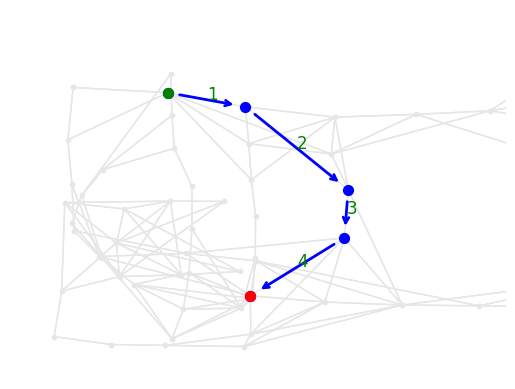

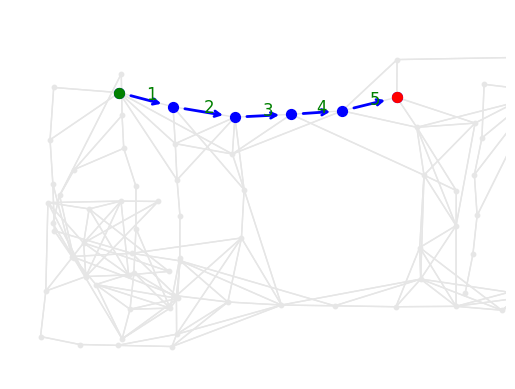

In [48]:
sampled = random.choice(list(comparisons['model1_traj']))
print(sampled)
print(e.instructions[sampled])
plot_each(get_ground_truth(sampled), e)
plot_each(comparisons['model1_traj'][sampled], e)

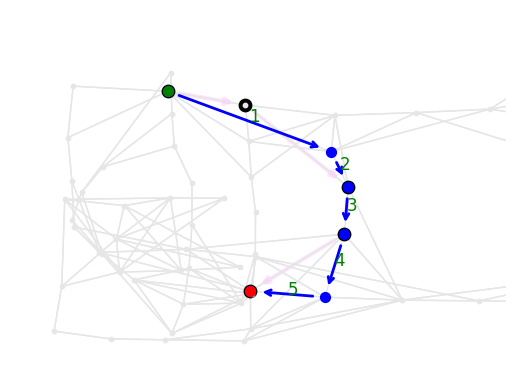

In [49]:
plot_each(comparisons['model2_traj'][sampled], e, True)

Walk through the sitting area and wait under the stairs next to the railing.


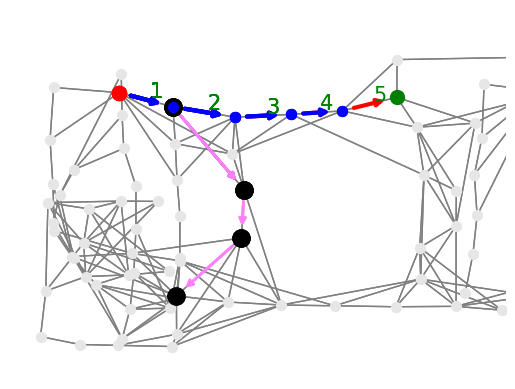

In [50]:
print(e.instructions[sampled])
plot_gif(comparisons['model1_traj'][sampled], e, True)